## 1. Import Libraries

In [111]:
import requests
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import time
import joblib

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

## 2. API Binance

In [112]:
base_url = "https://api.binance.com/api/v3/klines"

In [113]:
#Parametres search

symbol = "BTCUSDT" #Bitcoin (BTC/USDT)
interval = "1h" #Time interval
limit = 1000 #Data to take

In [114]:
#API apply

params = {
    "symbol" : symbol,
    "interval" : interval,
    "limit" : limit
}
response = requests.get(base_url, params= params)

#Convert data in json

data = response.json()

In [115]:
#Create the DataSet

df_cripto = pd.DataFrame(data, columns= ["timestamp", "open", "high", "low", "close", "volume",
    "close_time", "quote_asset_volume", "number_of_trades",
    "taker_buy_base", "taker_buy_quote", "ignore"
    ])

df_cripto.head()

,timestamp,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base,taker_buy_quote,ignore
0,1736539200000,95327.07000000,95442.15000000,94586.02000000,94672.05000000,1050.74200000,1736542799999,99750651.80787970,187954,484.27218000,45966191.83668670,0
1,1736542800000,94669.06000000,94923.05000000,94603.72000000,94613.26000000,443.76148000,1736546399999,42041940.80872930,78630,232.95541000,22068126.43330760,0
2,1736546400000,94613.26000000,94955.54000000,94586.03000000,94767.70000000,342.72272000,1736549999999,32461866.85386280,70050,199.43596000,18886861.90967490,0
3,1736550000000,94767.69000000,94894.81000000,94657.39000000,94726.11000000,300.04587000,1736553599999,28435793.21053020,49886,145.35090000,13777066.01995140,0
4,1736553600000,94726.10000000,94746.37000000,94360.65000000,94600.69000000,360.16333000,1736557199999,34048251.16432490,97992,133.46776000,12617065.84641760,0


In [116]:
#Convert data to numeric and dates

df_cripto["timestamp"] = pd.to_datetime(df_cripto["timestamp"], unit = "ms")
df_cripto["open"] = df_cripto["open"].astype(float)
df_cripto["high"] = df_cripto["high"].astype(float)
df_cripto["low"] = df_cripto["low"].astype(float)
df_cripto["close"] = df_cripto["close"].astype(float)
df_cripto["volume"] = df_cripto ["volume"].astype(float)

print(df_cripto[["timestamp", "open", "high", "low", "close", "volume"]].head(10))

            timestamp      open      high       low     close      volume
0 2025-01-10 20:00:00  95327.07  95442.15  94586.02  94672.05  1050.74200
1 2025-01-10 21:00:00  94669.06  94923.05  94603.72  94613.26   443.76148
2 2025-01-10 22:00:00  94613.26  94955.54  94586.03  94767.70   342.72272
3 2025-01-10 23:00:00  94767.69  94894.81  94657.39  94726.11   300.04587
4 2025-01-11 00:00:00  94726.10  94746.37  94360.65  94600.69   360.16333
5 2025-01-11 01:00:00  94600.70  94696.97  94214.38  94424.26   335.79125
6 2025-01-11 02:00:00  94424.26  94495.90  94180.00  94424.24   304.40657
7 2025-01-11 03:00:00  94424.24  94429.84  94106.49  94206.95   275.47256
8 2025-01-11 04:00:00  94206.96  94316.09  93831.73  94063.29   409.40458
9 2025-01-11 05:00:00  94063.29  94381.08  94013.51  94366.69   235.14105


In [117]:
df_cripto = df_cripto[["timestamp", "open", "high", "low", "close", "volume", "number_of_trades"]]

In [118]:
df_cripto.info()
df_cripto.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   timestamp         1000 non-null   datetime64[ns]
 1   open              1000 non-null   float64       
 2   high              1000 non-null   float64       
 3   low               1000 non-null   float64       
 4   close             1000 non-null   float64       
 5   volume            1000 non-null   float64       
 6   number_of_trades  1000 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 54.8 KB


,timestamp,open,high,low,close,volume,number_of_trades
0,2025-01-10 20:00:00,95327.07,95442.15,94586.02,94672.05,1050.74200,187954
1,2025-01-10 21:00:00,94669.06,94923.05,94603.72,94613.26,443.76148,78630
2,2025-01-10 22:00:00,94613.26,94955.54,94586.03,94767.70,342.72272,70050
3,2025-01-10 23:00:00,94767.69,94894.81,94657.39,94726.11,300.04587,49886
4,2025-01-11 00:00:00,94726.10,94746.37,94360.65,94600.69,360.16333,97992
5,2025-01-11 01:00:00,94600.70,94696.97,94214.38,94424.26,335.79125,87225
6,2025-01-11 02:00:00,94424.26,94495.90,94180.00,94424.24,304.40657,66228
7,2025-01-11 03:00:00,94424.24,94429.84,94106.49,94206.95,275.47256,64375
8,2025-01-11 04:00:00,94206.96,94316.09,93831.73,94063.29,409.40458,73006
9,2025-01-11 05:00:00,94063.29,94381.08,94013.51,94366.69,235.14105,56817


## 3. Feature Clean and Creation

In [119]:
# Simple Media (SMA)

df_cripto["SMA_7"] = df_cripto["close"].rolling(window=7).mean()
df_cripto["SMA_21"] = df_cripto["close"].rolling(window=21).mean()

# Exponencial Movil Media   
df_cripto["EMA_7"] = df_cripto["close"].ewm(span= 7, adjust=False).mean()
df_cripto["EMA_21"] = df_cripto["close"].ewm(span=21, adjust=False).mean()

# Volatility (STD Last 7 periods)
df_cripto["volatility_7"] = df_cripto["close"].rolling(window=7).std()

# Logaritmic Return
df_cripto["log_return"] = np.log(df_cripto["close"] / df_cripto["close"].shift(1))


#Relative Strong Index (RSI)

def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0,0)).rolling(window= period).mean()
    loss = (-delta.where(delta < 0,0)).rolling(window=period).mean()
    rs = gain/ loss
    return 100 - (100 /(1 +rs))

df_cripto["RSI_14"] = calculate_rsi(df_cripto["close"], 14)

print(df_cripto.head(20))

             timestamp      open      high       low     close      volume  \
0  2025-01-10 20:00:00  95327.07  95442.15  94586.02  94672.05  1050.74200   
1  2025-01-10 21:00:00  94669.06  94923.05  94603.72  94613.26   443.76148   
2  2025-01-10 22:00:00  94613.26  94955.54  94586.03  94767.70   342.72272   
3  2025-01-10 23:00:00  94767.69  94894.81  94657.39  94726.11   300.04587   
4  2025-01-11 00:00:00  94726.10  94746.37  94360.65  94600.69   360.16333   
5  2025-01-11 01:00:00  94600.70  94696.97  94214.38  94424.26   335.79125   
6  2025-01-11 02:00:00  94424.26  94495.90  94180.00  94424.24   304.40657   
7  2025-01-11 03:00:00  94424.24  94429.84  94106.49  94206.95   275.47256   
8  2025-01-11 04:00:00  94206.96  94316.09  93831.73  94063.29   409.40458   
9  2025-01-11 05:00:00  94063.29  94381.08  94013.51  94366.69   235.14105   
10 2025-01-11 06:00:00  94366.70  94441.87  94216.25  94216.25   150.60139   
11 2025-01-11 07:00:00  94216.26  94333.34  94151.51  94246.36  

In [120]:
print(df_cripto.isnull().sum())

timestamp            0
open                 0
high                 0
low                  0
close                0
volume               0
number_of_trades     0
SMA_7                6
SMA_21              20
EMA_7                0
EMA_21               0
volatility_7         6
log_return           1
RSI_14              13
dtype: int64


In [121]:
df_cripto = df_cripto.dropna().reset_index()
df_cripto.drop("index", inplace= True, axis= 1)

In [122]:
df_cripto.head(20)

,timestamp,open,high,low,close,volume,number_of_trades,SMA_7,SMA_21,EMA_7,EMA_21,volatility_7,log_return,RSI_14
0,2025-01-11 16:00:00,94410.26,94708.12,94312.56,94448.14,278.46964,63889,94506.132857,94441.667619,94456.885810,94463.585101,94.243007,0.000401,50.528625
1,2025-01-11 17:00:00,94448.14,94448.14,93984.55,94151.52,422.01065,83462,94457.941429,94416.880476,94380.544358,94435.215546,164.562803,-0.003146,48.815553
2,2025-01-11 18:00:00,94151.51,94306.62,94121.00,94275.79,171.50586,43902,94407.961429,94400.810476,94354.355768,94420.722315,158.141535,0.001319,54.578715
3,2025-01-11 19:00:00,94275.79,94327.40,94084.64,94249.26,144.36313,35540,94364.997143,94376.122857,94328.081826,94405.134832,153.915187,-0.000281,47.126954
4,2025-01-11 20:00:00,94249.27,94668.31,94200.89,94586.11,282.09991,69007,94391.582857,94369.456190,94392.588870,94421.587120,175.526210,0.003568,58.292602
5,2025-01-11 21:00:00,94586.12,95050.94,94575.75,94940.76,818.05763,100885,94437.405714,94385.650000,94529.631652,94468.784654,264.442718,0.003742,63.591169
6,2025-01-11 22:00:00,94940.75,95005.00,94561.00,94593.80,532.69589,61204,94463.625714,94393.723333,94545.673739,94480.149686,270.336078,-0.003661,59.505712
7,2025-01-11 23:00:00,94593.80,94753.37,94541.66,94599.99,231.83722,54156,94485.318571,94402.092381,94559.252804,94491.044260,274.939667,0.000065,55.451094
8,2025-01-12 00:00:00,94599.99,94655.22,94422.13,94452.07,320.75584,71212,94528.254286,94413.764762,94532.457103,94487.501145,234.638223,-0.001565,49.255272
9,2025-01-12 01:00:00,94452.08,94589.46,94296.99,94580.00,300.67295,57063,94571.712857,94438.370000,94544.342827,94495.910132,206.579059,0.001354,49.072596


## 4. Data Visualization (Mini EDA)

In [123]:
sns.set_style("darkgrid")

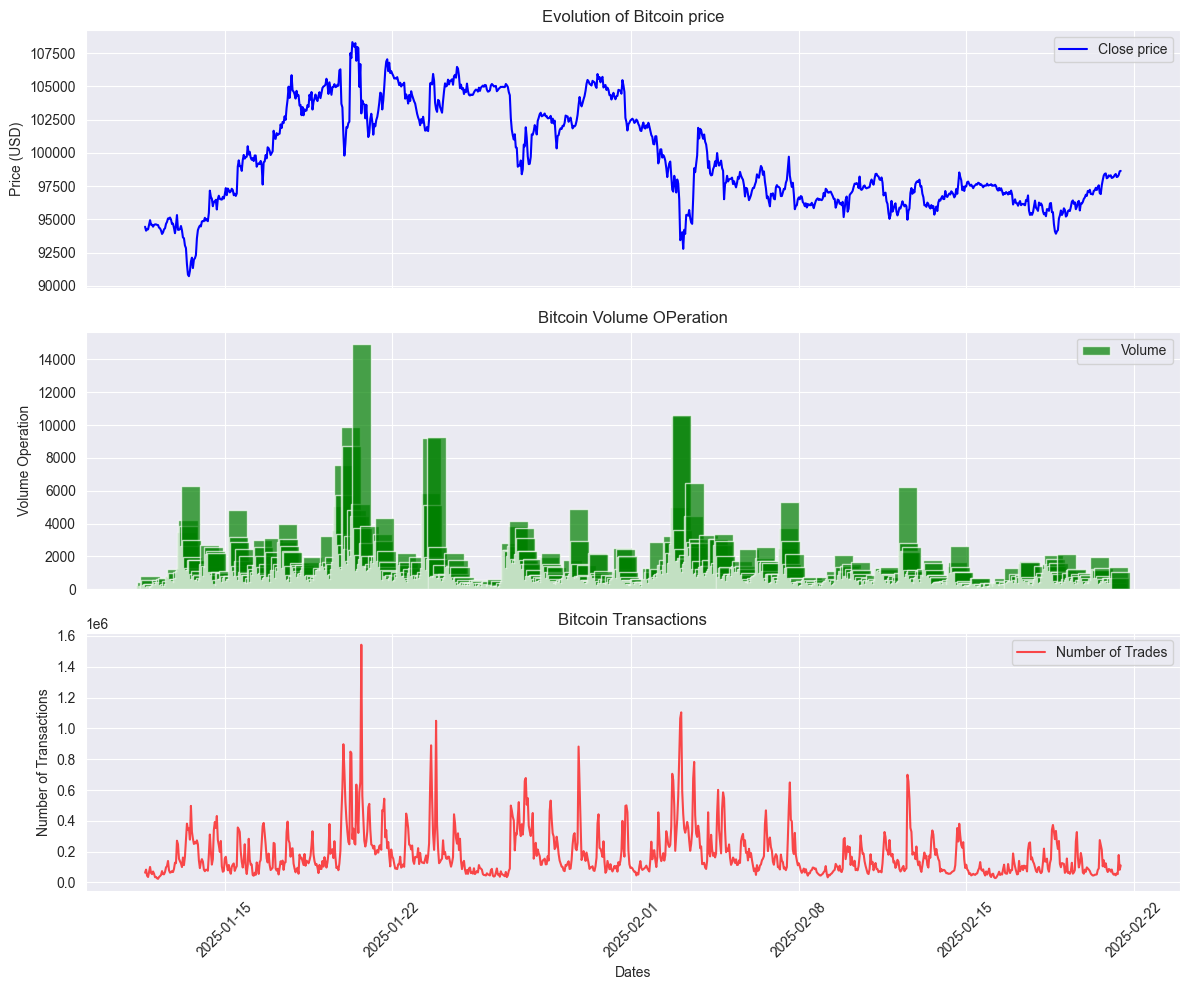

In [124]:
fig, axes = plt.subplots(3,1, figsize= (12,10), sharex = True)

# Evolution of Bitcoin Price Graphic

axes[0].plot(df_cripto["timestamp"], df_cripto["close"], color= "blue", label= "Close price")
axes[0].set_ylabel("Price (USD)")
axes[0].set_title("Evolution of Bitcoin price")
axes[0].legend()

# Volume Operation Graphic
axes[1].bar(df_cripto["timestamp"], df_cripto["volume"],color = "green",alpha= 0.7, label = "Volume")
axes[1].set_ylabel("Volume Operation")
axes[1].set_title("Bitcoin Volume OPeration")
axes[1].legend()

# Number of Transactions Graphic
axes[2].plot(df_cripto["timestamp"], df_cripto["number_of_trades"], color= "red", alpha= 0.7, label= "Number of Trades")
axes[2].set_ylabel("Number of Transactions")
axes[2].set_title("Bitcoin Transactions")
axes[2].legend()

# Format X axis
plt.xticks(rotation = 45)
plt.xlabel("Dates")
plt.tight_layout()

#Show
plt.show()

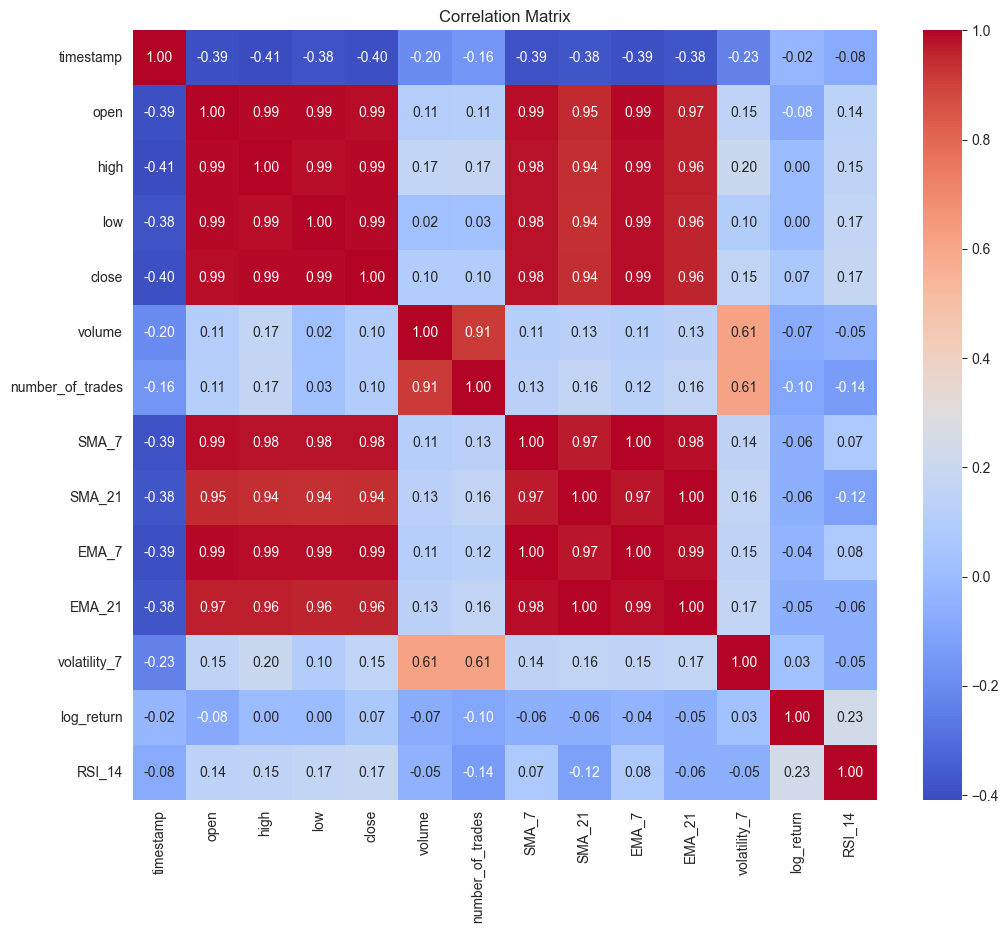

In [125]:
# Correlation

plt.figure(figsize=(12,10))
sns.heatmap(df_cripto.corr(), annot= True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

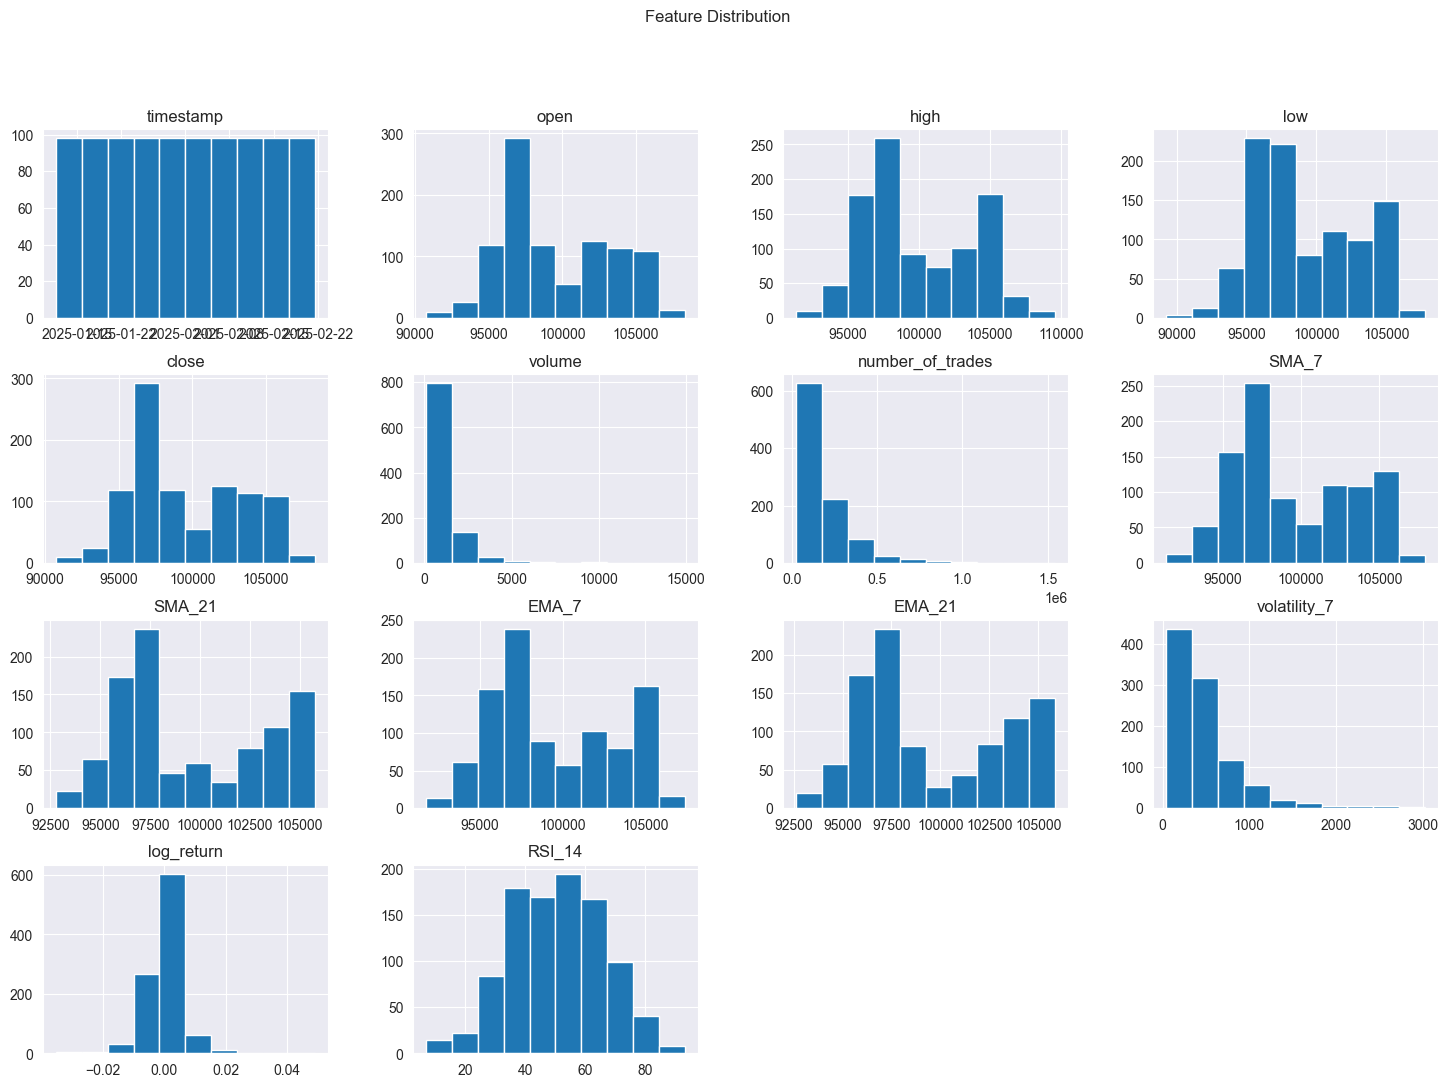

In [126]:
#Feature Distribution

df_cripto.hist(figsize=(18,12))
plt.suptitle("Feature Distribution")
plt.show()

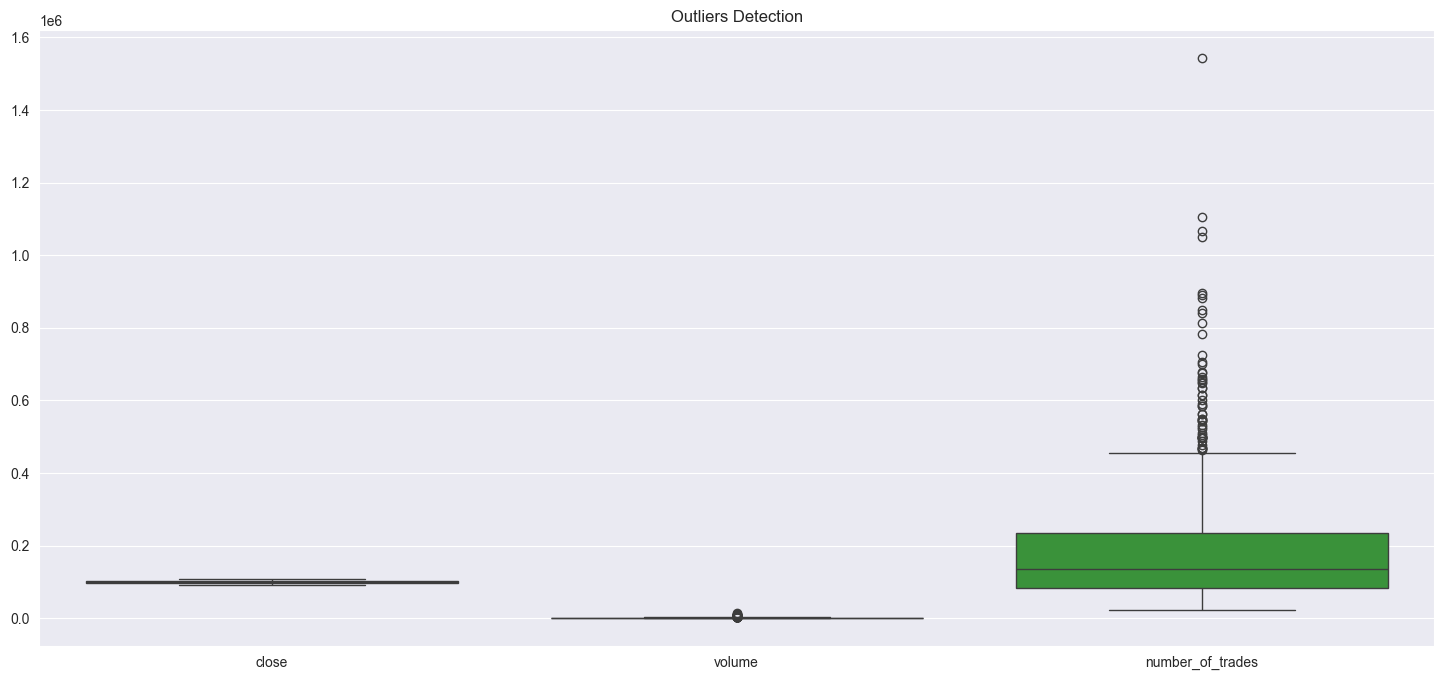

In [127]:
#Outliers

plt.figure(figsize=(18, 8))
sns.boxplot(data=df_cripto[["close", "volume", "number_of_trades"]])
plt.title("Outliers Detection")
plt.show()

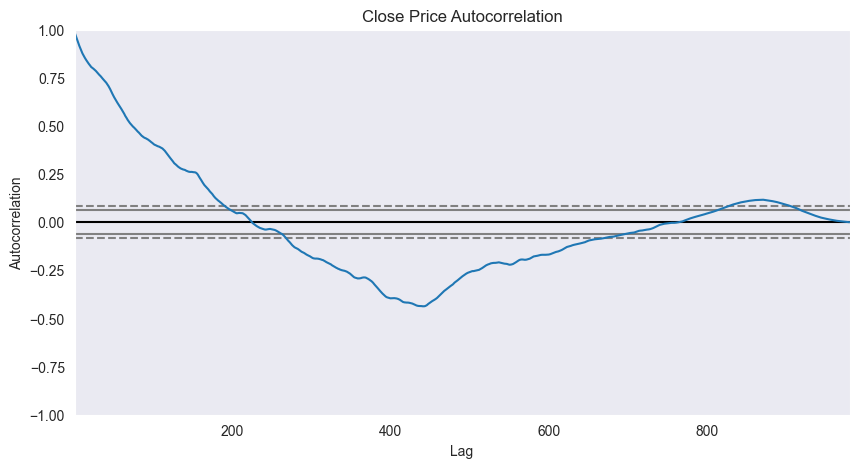

In [128]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize= (10,5))
autocorrelation_plot(df_cripto["close"])
plt.title("Close Price Autocorrelation")
plt.show()

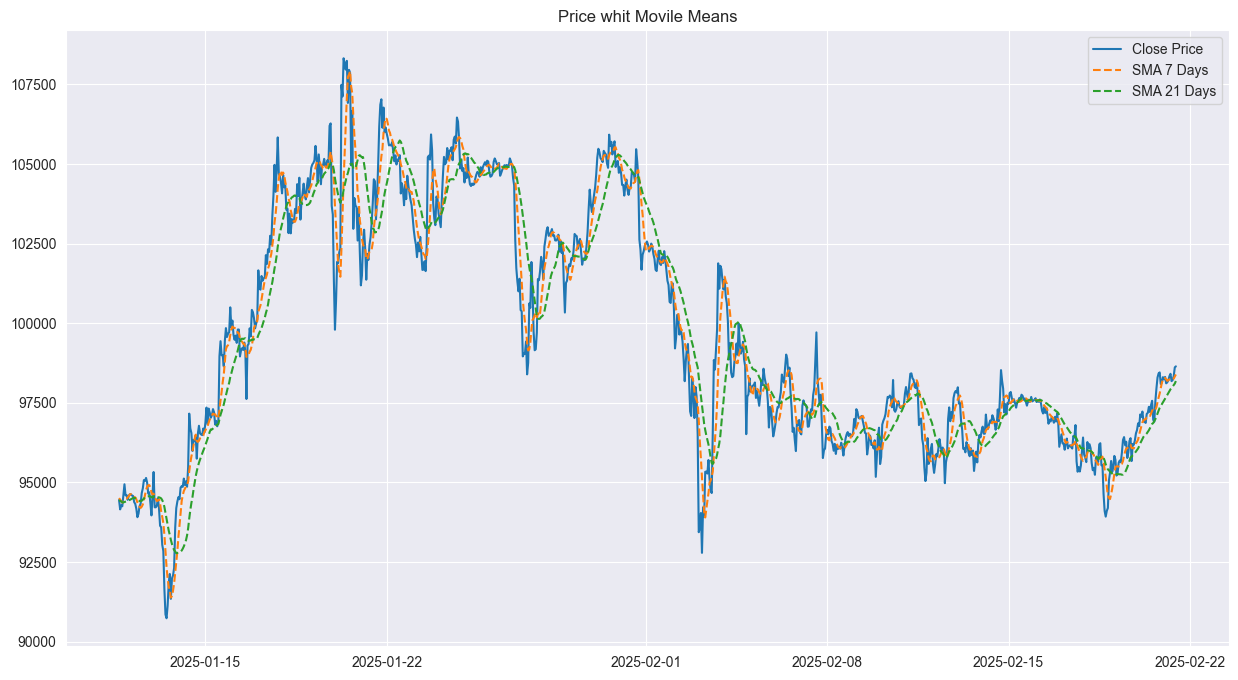

In [129]:
plt.figure(figsize=(15,8))
plt.plot(df_cripto["timestamp"], df_cripto["close"], label = "Close Price")
plt.plot(df_cripto["timestamp"], df_cripto["SMA_7"], label= "SMA 7 Days", linestyle= "dashed")
plt.plot(df_cripto["timestamp"], df_cripto["SMA_21"], label= "SMA 21 Days", linestyle= "dashed")
plt.legend()
plt.title("Price whit Movile Means")
plt.show()

## 5. Feature Engineering

In [130]:
# Remove useless features

df_cripto.drop(["low", "high", "open", "number_of_trades"], inplace= True, axis= 1)

In [131]:
volume_tensor = tf.convert_to_tensor(df_cripto["volume"], dtype=tf.float32)

log_volume_tensor = tf.math.log(volume_tensor + 1)

df_cripto["log_volume"] = log_volume_tensor.numpy()

df_cripto.drop("volume", inplace= True, axis= 1)

In [132]:
df_cripto

,timestamp,close,SMA_7,SMA_21,EMA_7,EMA_21,volatility_7,log_return,RSI_14,log_volume
0,2025-01-11 16:00:00,94448.14,94506.132857,94441.667619,94456.885810,94463.585101,94.243007,0.000401,50.528625,5.632894
1,2025-01-11 17:00:00,94151.52,94457.941429,94416.880476,94380.544358,94435.215546,164.562803,-0.003146,48.815553,6.047398
2,2025-01-11 18:00:00,94275.79,94407.961429,94400.810476,94354.355768,94420.722315,158.141535,0.001319,54.578715,5.150431
3,2025-01-11 19:00:00,94249.26,94364.997143,94376.122857,94328.081826,94405.134832,153.915187,-0.000281,47.126954,4.979235
4,2025-01-11 20:00:00,94586.11,94391.582857,94369.456190,94392.588870,94421.587120,175.526210,0.003568,58.292602,5.645800
...,...,...,...,...,...,...,...,...,...,...
975,2025-02-21 07:00:00,98179.76,98241.778571,97962.119048,98240.778226,97935.790837,111.022389,-0.002342,55.756418,6.554670
976,2025-02-21 08:00:00,98213.41,98227.694286,98009.999524,98233.936170,97961.028943,106.802764,0.000343,47.519454,5.913641
977,2025-02-21 09:00:00,98337.70,98260.062857,98053.301429,98259.877127,97995.271766,99.681664,0.001265,47.409878,7.196462
978,2025-02-21 10:00:00,98612.00,98327.207143,98103.292381,98347.907845,98051.337969,151.645789,0.002785,54.198498,6.564717


## 6. Train Test Split


In [133]:
# First, we let's make a copy

df_cripto_scaled = df_cripto.copy()

df_cripto_scaled.drop(["SMA_21", "EMA_21"], axis= 1, inplace= True)
features = ["close", "volatility_7", "log_return", "log_volume", "SMA_7", "RSI_14"]
target = "close"

# Split 

X_train, X_test, y_train, y_test = train_test_split(df_cripto_scaled[features], df_cripto_scaled[target], test_size=0.2, random_state=42)


In [134]:
# Sequence for LSTM

def create_sequence(X, y, timesteps= 60):
    Xs, ys = [], []

    for i in range(len(X)- timesteps):
        Xs.append(X[i : i + timesteps])
        ys.append(y[i : i +timesteps])

    return np.array(Xs), np.array(ys)


In [135]:
# Apply function

timesteps = 60

X_train_seq, y_train_seq = create_sequence(X_train, y_train, timesteps)
X_test_seq, y_test_seq = create_sequence(X_test, y_test, timesteps)


print(f"Shape of X_train: {X_train_seq.shape}")
print(f"Shape of y_train: {y_train_seq.shape}")

Shape of X_train: (724, 60, 6)
Shape of y_train: (724, 60)


## 7. LSTM Model

In [136]:
#LSTM model

model = Sequential([
    LSTM(50, return_sequences=True, input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])), #First cape
    Dropout(0.2),

    LSTM(50, return_sequences=False),
    Dropout(0.2),

    Dense(25, activation="linear"),
    Dense(1)
])

model.compile(optimizer = "adam", loss = "mae")

model.summary()

c:\Users\shark\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 60, 50)         │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,901 (128.52 KB)

 Trainable params: 32,901 (128.52 KB)

 Non-trainable params: 0 (0.00 B)

In [137]:
#Train

history = model.fit(X_train_seq, y_train_seq,
                    epochs= 50, batch_size = 32,
                    validation_data = (X_test_seq, y_test_seq))

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - loss: 99535.2500 - val_loss: 99567.7344
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 99541.0703 - val_loss: 99555.3359
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 99508.4531 - val_loss: 99539.6172
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 99483.4688 - val_loss: 99521.4375
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 99495.0391 - val_loss: 99500.5938
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 99452.7188 - val_loss: 99476.8125
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 99423.9609 - val_loss: 99449.8125
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 99383.9531 - val_loss: 99419.5938
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 99365.2734 - val_loss: 99386.0859
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 99327.8125 - val_loss: 99349.3125
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 99306.085

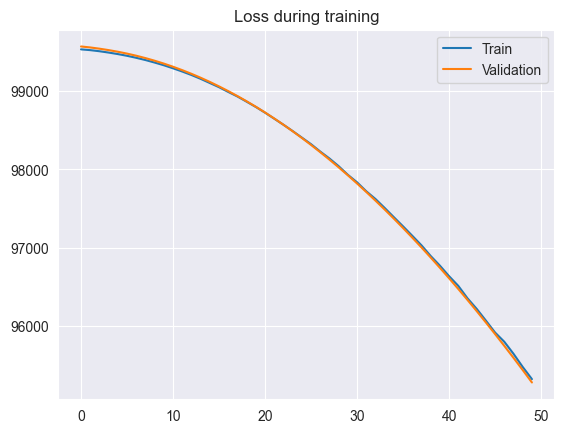

In [138]:
plt.plot(history.history["loss"],label = "Train")
plt.plot(history.history["val_loss"], label = "Validation")
plt.legend()
plt.title("Loss during training")
plt.show()